In [2]:
!pip install seaborn

In [6]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8')
%matplotlib inline

from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram

# Bank Customer Segmentation Analysis - Student Exercise

In this lab, you will implement customer segmentation using K-means clustering. You'll learn how to:
1. Preprocess data for clustering
2. Perform and visualize dimensionality reduction
3. Implement K-means clustering from scratch
4. Evaluate clustering results

Follow the instructions in each section and fill in the code where indicated.

In [7]:
# Load Data and Preprocess
def load_data(filepath):
    df = pd.read_csv(filepath, sep=';')
    return df

# Apply PCA for Dimensionality Reduction
def apply_pca(x, n_components):
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(x)

    # Explained variance
    explained_variance = pca.explained_variance_ratio_

    # Plot
    plt.figure(figsize=(12, 4))

    # Explained variance bar plot
    plt.subplot(1, 2, 1)
    plt.bar(range(1, n_components + 1), explained_variance, alpha=0.5, align='center')
    plt.xlabel('Principal Components')
    plt.ylabel('Explained Variance Ratio')
    plt.title('Explained Variance by Component')

    # Cumulative explained variance
    plt.step(range(1, n_components + 1), np.cumsum(explained_variance), where='mid', label='Cumulative')
    plt.legend()

    # Data distribution in 2D
    plt.subplot(1, 2, 2)
    plt.scatter(X_pca[:, 0], X_pca[:, 1])
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('Data Distribution in PCA Space')

    plt.tight_layout()
    plt.show()
    return X_pca

# Find Optimal Clusters for KMeans (Elbow Method)
def find_optimal_clusters(x, max_clusters=10):
    inertias = []
    silhouette_scores = []
    K = range(2, max_clusters + 1)

    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(x)
        inertias.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(x, kmeans.labels_))

    # Plot inertia (elbow)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(K, inertias, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Inertia')
    plt.title('Inertia Plot (Elbow Method)')

    # Plot silhouette
    plt.subplot(1, 2, 2)
    plt.plot(K, silhouette_scores, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score Plot')

    plt.tight_layout()
    plt.show()
    return inertias, silhouette_scores

# Perform KMeans Clustering
# Change None to the number of n_clusters value from the elbow method
def perform_kmeans_clustering(x, n_clusters=4):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(x)
    return labels, kmeans.cluster_centers_

# Perform Agglomerative Clustering
# Change None to the number of n_clusters value from the elbow method
def perform_agglomerative_clustering(x, n_clusters=4):
    agg = AgglomerativeClustering(n_clusters=n_clusters)
    labels = agg.fit_predict(x)
    return labels

def get_linkages(x):
    linked = linkage(x, 'ward')
    return linked

# Plot Dendrogram
def plot_dendrogram(linked):
    plt.figure(figsize=(10, 7))
    dendrogram(linked)
    plt.title('Dendrogram')
    plt.show()

## 1. Data Loading and Preprocessing

First, complete the data preprocessing function below. You need to:
1. Load the data
2. Handle categorical variables
3. Scale numerical features

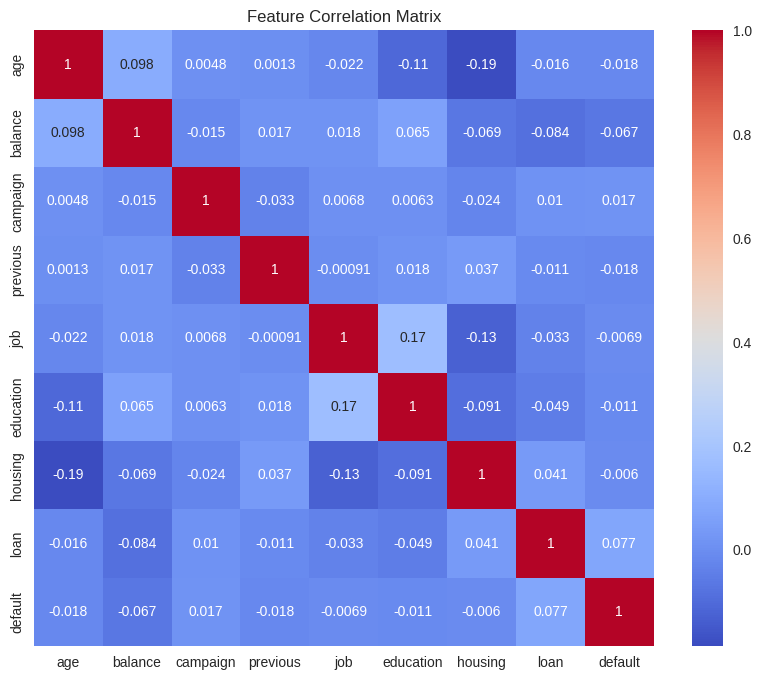

Data shape: (45211, 9)


In [12]:
def load_data(filepath):
    # Load data
    df = pd.read_csv(filepath, sep=';')

    # List of categorical columns to encode
    categorical_cols = ['job', 'marital', 'education', 'default', 'housing',
                       'loan', 'contact', 'month', 'poutcome', 'y']

    # TODO: Apply label encoding to categorical columns
    le = LabelEncoder()
    for col in categorical_cols:
        df[col] = le.fit_transform(df[col])

    # Select features for clustering
    features = ['age', 'balance', 'campaign', 'previous', 'job', 'education',
               'housing', 'loan', 'default']
    X = df[features]

    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Add correlation heatmap for report
    plt.figure(figsize=(10, 8))
    sns.heatmap(df[features].corr(), annot=True, cmap='coolwarm')
    plt.title('Feature Correlation Matrix')
    plt.show()

    return X_scaled, df

# Load and preprocess the data
X_scaled, data = load_data('bank-full.csv')
print("Data shape:", X_scaled.shape)

In [13]:
class KMeansClustering:
    def __init__(self, n_clusters=3, max_iters=100, random_state=42):
        self.n_clusters = n_clusters
        self.max_iters = max_iters
        self.random_state = random_state
        self.centroids = None
        self.labels = None

    def _initialize_centroids(self, X):
        np.random.seed(self.random_state)
        indices = np.random.choice(len(X), self.n_clusters, replace=False)
        return X[indices]

    def _assign_clusters(self, X):
        distances = np.array([np.linalg.norm(X - centroid, axis=1) for centroid in self.centroids])
        return np.argmin(distances, axis=0)

    def _update_centroids(self, X, labels):
        new_centroids = []
        for i in range(self.n_clusters):
            points = X[labels == i]
            if len(points) > 0:
                new_centroids.append(points.mean(axis=0))
            else:
                new_centroids.append(self.centroids[i])  # Keep unchanged if empty
        return np.array(new_centroids)

    def fit(self, X):
        self.centroids = self._initialize_centroids(X)
        for _ in range(self.max_iters):
            labels = self._assign_clusters(X)
            new_centroids = self._update_centroids(X, labels)
            if np.allclose(self.centroids, new_centroids, atol=1e-4):
                break
            self.centroids = new_centroids
        self.labels = labels
        return self

    def predict(self, X):
        if self.centroids is None:
            raise ValueError("Model has not been fitted yet. Call fit(X) first.")
        return self._assign_clusters(X)

## 2. Dimensionality Reduction

Before clustering, we often reduce the dimensionality of our data for better visualization and performance. Implement PCA below:

In [14]:
def apply_pca(X, n_components=2):

    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)

    # TODO: Create visualization
    plt.figure(figsize=(12, 4))

    # Plot explained variance
    # Your code here

    # Plot data in 2D
    # Your code here

    return X_pca

# Apply PCA
X_pca = apply_pca(X_scaled, n_components=2)
print("Shape after PCA:", X_pca.shape)

Shape after PCA: (45211, 2)


<Figure size 1200x400 with 0 Axes>

## 3. Clustering Evaluation

Implement functions to evaluate the quality of your clustering results:

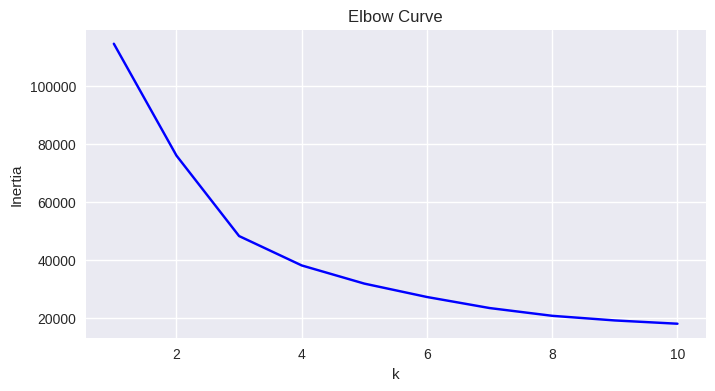

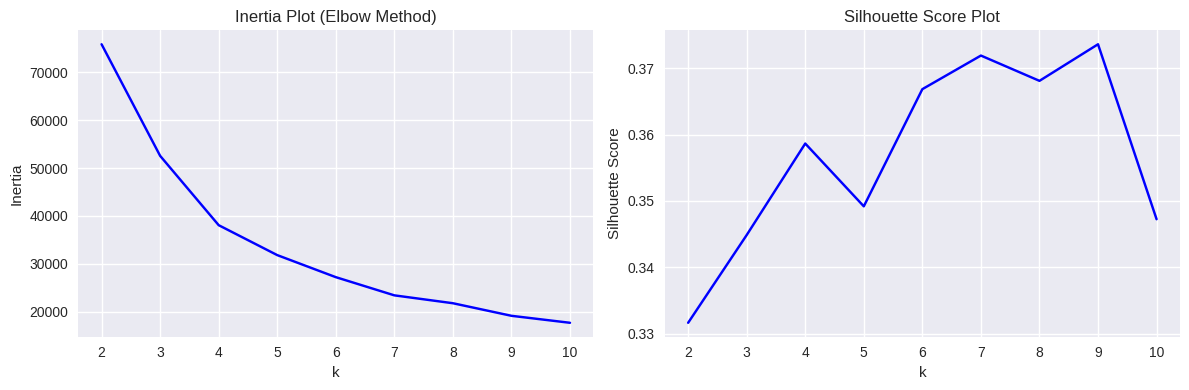

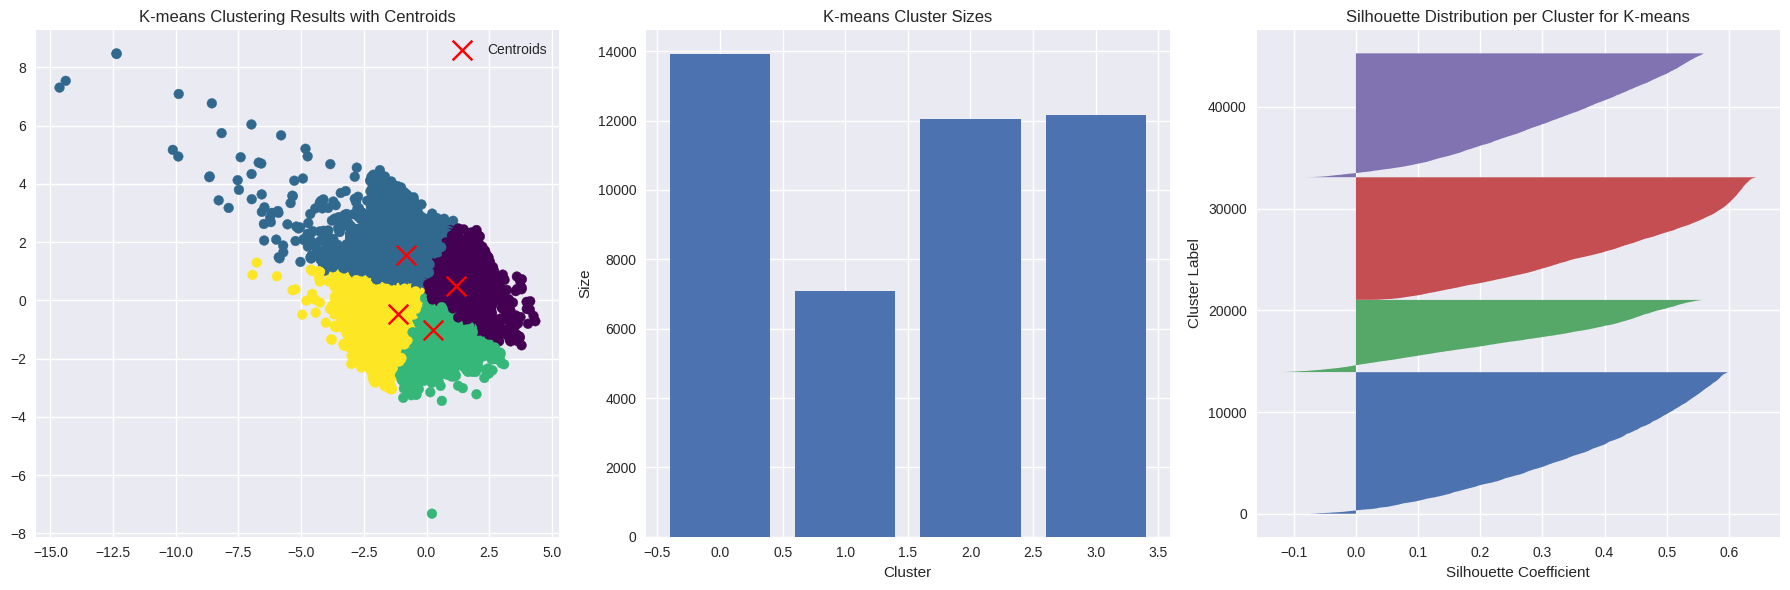


Clustering Evaluation:
Inertia: 38059.02
Silhouette Score: 0.36


In [15]:
def calculate_inertia(X, labels, centroids):

    inertia = 0
    for i in range(len(centroids)):
        points = X[labels == i]
        if len(points) > 0:
            inertia += np.sum((points - centroids[i]) ** 2)
    return inertia

def plot_elbow_curve(X, max_k=10):
    inertias = []
    K = range(1, max_k + 1)

    # Calculate inertia for different k values
    for k in K:
        kmeans = KMeansClustering(n_clusters=k)
        kmeans.fit(X)
        inertias.append(calculate_inertia(X, kmeans.labels, kmeans.centroids))

    # Create elbow plot
    plt.figure(figsize=(8, 4))
    plt.plot(K, inertias, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Inertia')
    plt.title('Elbow Curve')
    plt.show()

    return inertias

# Try different numbers of clusters
inertias = plot_elbow_curve(X_pca)

# Find optimal clusters
_ = find_optimal_clusters(X_pca)

# Apply final clustering
kmeans = KMeansClustering(n_clusters=4)  # Adjust based on elbow/silhouette (e.g., 4)
kmeans.fit(X_pca)

# Visualize final results
plt.figure(figsize=(18, 6))

# Plot clusters (scatter)
plt.subplot(1, 3, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels, cmap='viridis')
plt.scatter(kmeans.centroids[:, 0], kmeans.centroids[:, 1],
            c='red', marker='x', s=200, label='Centroids')
plt.title('K-means Clustering Results with Centroids')
plt.legend()

# Plot cluster sizes (bar)
plt.subplot(1, 3, 2)
unique, counts = np.unique(kmeans.labels, return_counts=True)
plt.bar(unique, counts)
plt.xlabel('Cluster')
plt.ylabel('Size')
plt.title('K-means Cluster Sizes')

# Plot silhouette per cluster (box plot)
sil_scores = silhouette_score(X_pca, kmeans.labels)  # Overall
# Per-cluster silhouette (for box plot)
from sklearn.metrics import silhouette_samples
sample_sil = silhouette_samples(X_pca, kmeans.labels)
plt.subplot(1, 3, 3)
y_lower = 10
for i in range(kmeans.n_clusters):
    ith_sil = sample_sil[kmeans.labels == i]
    ith_sil.sort()
    y_upper = y_lower + ith_sil.shape[0]
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_sil)
    y_lower = y_upper + 10
plt.title('Silhouette Distribution per Cluster for K-means')
plt.xlabel('Silhouette Coefficient')
plt.ylabel('Cluster Label')

plt.tight_layout()
plt.show()

# Calculate and print evaluation metrics
inertia = calculate_inertia(X_pca, kmeans.labels, kmeans.centroids)
silhouette = silhouette_score(X_pca, kmeans.labels)

print("\nClustering Evaluation:")
print(f"Inertia: {inertia:.2f}")
print(f"Silhouette Score: {silhouette:.2f}")

## 4. Recursive Bisecting K-means (Student exercise)

This is an optional exercise for students who want to explore a hierarchical variant of K-means.

Task: implement a concise bisecting K-means procedure that recursively splits clusters into two until a target number of clusters is reached.

Learning goals:
- Understand how repeated binary splits can form a hierarchical clustering
- Practice applying K-means on subclusters and tracking labels/centroids

Hints:
- You can use sklearn's KMeans(k=2) for the binary split step, or reuse your `KMeansClustering` implementation.
- Keep label bookkeeping simple: use increasing integer labels for new clusters.
- Store split metadata (parent -> left/right) to enable a tree visualization later.

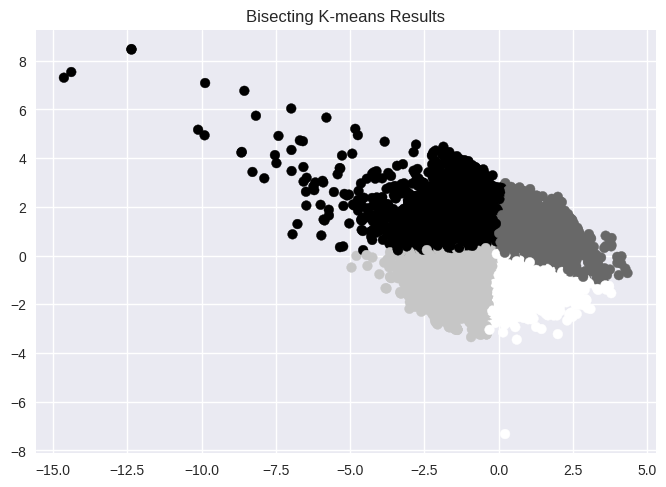

In [16]:
class BisectingKMeans:
    def __init__(self, n_clusters, random_state=42):
        self.n_clusters = n_clusters
        self.random_state = random_state
        self.labels_ = None
        self.split_tree = {}
        self.centers_ = {}

    def fit_predict(self, X):
        n_samples = len(X)
        self.labels_ = np.zeros(n_samples, dtype=int)  # Start with cluster 0
        current_clusters = 1
        next_label = 1  # Next available label

        while current_clusters < self.n_clusters:
            cluster_sizes = np.bincount(self.labels_)
            cluster_to_split = np.argmax(cluster_sizes)

            # Get points in that cluster
            mask = self.labels_ == cluster_to_split
            sub_X = X[mask]

            if len(sub_X) < 2:
                break  # Can't split

            # Binary K-means
            kmeans = KMeans(n_clusters=2, random_state=self.random_state)
            sub_labels = kmeans.fit_predict(sub_X)

            # Assign new labels: keep 0 as original, 1 as new
            new_mask = sub_labels == 1
            self.labels_[mask] = np.where(new_mask, next_label, cluster_to_split)

            # Record split
            self.split_tree[cluster_to_split] = (cluster_to_split, next_label)

            # Centroids
            self.centers_[cluster_to_split] = kmeans.cluster_centers_[0]
            self.centers_[next_label] = kmeans.cluster_centers_[1]

            next_label += 1
            current_clusters += 1

        return self.labels_

# Example usage (run to test)
bisect = BisectingKMeans(n_clusters=4)
labels = bisect.fit_predict(X_pca)
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels)
plt.title('Bisecting K-means Results')
plt.show()

## Bonus Challenges

If you've completed the main tasks, try these extensions:

1. Implement k-means++ initialization
   - Instead of random initialization, use the k-means++ algorithm
   - This should give better and more consistent results

2. Add cluster interpretation
   - Analyze the characteristics of each cluster
   - What features distinguish one cluster from another?
   - Create visualizations to show cluster properties

3. Try different distance metrics
   - Implement Manhattan distance instead of Euclidean
   - Compare the clustering results

4. Add outlier detection
   - Identify points far from all centroids
   - How might you handle these outliers?

Remember to document your code and explain your findings!

**BONUS CHALLENGES**

**1. k-means++ initialization**

In [24]:
def kmeans_plus_plus_init(X, n_clusters, random_state=None):
    """Return initial centroids using k-means++."""
    if random_state is not None:
        np.random.seed(random_state)
    n_samples = X.shape[0]
    centroids = np.empty((n_clusters, X.shape[1]))

    # First centroid: random
    centroids[0] = X[np.random.randint(n_samples)]

    for c in range(1, n_clusters):
        # Min squared distance to any existing centroid
        dists = np.min([np.sum((X - centroids[i])**2, axis=1) for i in range(c)], axis=0)
        if dists.sum() == 0:
            idx = np.random.randint(n_samples)
        else:
            probs = dists / dists.sum()
            cumprobs = np.cumsum(probs)
            r = np.random.rand()
            idx = np.searchsorted(cumprobs, r)
            idx = min(idx, n_samples - 1)  # <-- SAFETY CLAMP
        centroids[c] = X[idx]

    return centroids

# Apply to your KMeansClustering class
if 'KMeansClustering' in globals():
    KMeansClustering._initialize_centroids = lambda self, X: kmeans_plus_plus_init(
        X, self.n_clusters, self.random_state
    )
    print("k-means++ initialization applied.")
else:
    print("KMeansClustering not defined. Run class definition first.")

k-means++ initialization applied.


**2. CLUSTER INTERPRETATION**


=== Mean Feature Values per Cluster ===
           age  balance  campaign  previous
cluster                                    
0        39.60   710.03      2.66      0.55
1        54.84  2981.15      2.74      0.46
2        34.47   671.32      2.70      0.73
3        40.76  1847.80      2.96      0.53


/tmp/ipython-input-2760737807.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y='age', data=data, ax=axes[0], palette='Set2')
/tmp/ipython-input-2760737807.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y='balance', data=data, ax=axes[1], palette='Set2')


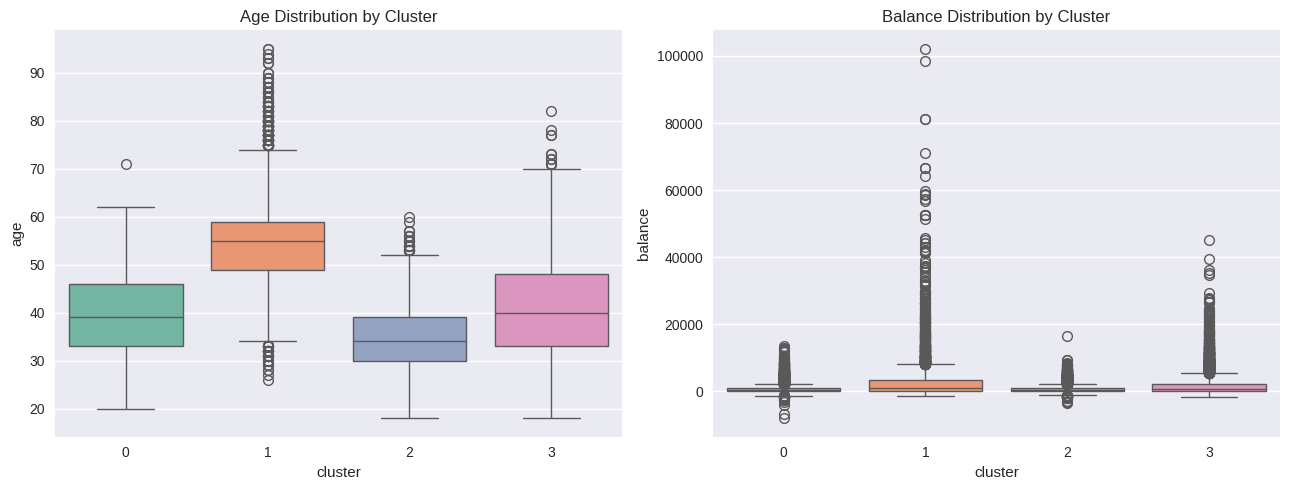

In [26]:
if 'data' in globals() and 'kmeans' in globals():
    data['cluster'] = kmeans.labels

    print("\n=== Mean Feature Values per Cluster ===")
    means = data.groupby('cluster')[['age', 'balance', 'campaign', 'previous']].mean().round(2)
    print(means)

    # Box plots
    fig, axes = plt.subplots(1, 2, figsize=(13, 5))
    sns.boxplot(x='cluster', y='age', data=data, ax=axes[0], palette='Set2')
    sns.boxplot(x='cluster', y='balance', data=data, ax=axes[1], palette='Set2')
    axes[0].set_title('Age Distribution by Cluster')
    axes[1].set_title('Balance Distribution by Cluster')
    plt.tight_layout()
    plt.show()
else:
    print("data or kmeans not defined.")

**3. MANHATTAN DISTANCE**


Silhouette Scores:
Euclidean (original) : 0.3581
Manhattan (L1)       : 0.3509


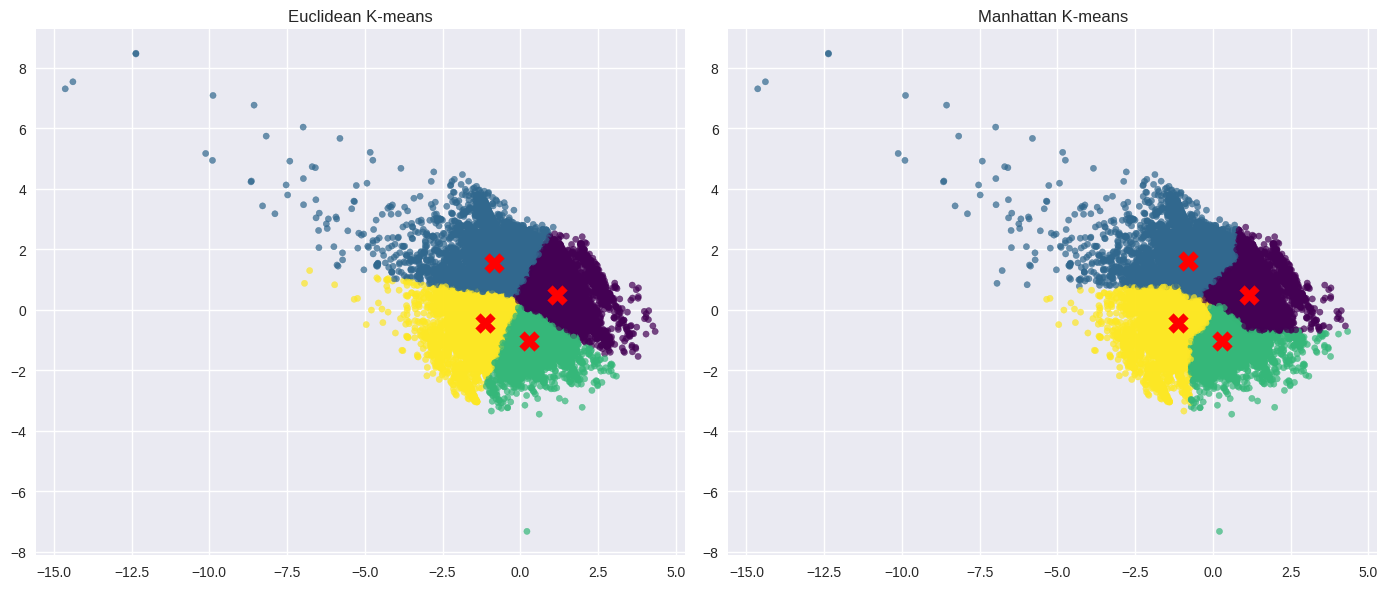

In [29]:
if 'KMeansClustering' in globals() and 'X_pca' in globals():
    class KMeansManhattan(KMeansClustering):
        def _assign_clusters(self, X):
            # L1 distance: sum of absolute differences
            return np.argmin([np.sum(np.abs(X - c), axis=1) for c in self.centroids], axis=0)

    # DO NOT pass max_iter — your class doesn't accept it
    kmeans_l1 = KMeansManhattan(n_clusters=4, random_state=42)
    kmeans_l1.fit(X_pca)  # This will now work

    print("\nSilhouette Scores:")
    print(f"Euclidean (original) : {silhouette_score(X_pca, kmeans.labels):.4f}")
    print(f"Manhattan (L1)       : {silhouette_score(X_pca, kmeans_l1.labels):.4f}")

    # Plot
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    ax[0].scatter(X_pca[:,0], X_pca[:,1], c=kmeans.labels, cmap='viridis', s=20, alpha=0.7)
    ax[0].scatter(kmeans.centroids[:,0], kmeans.centroids[:,1], c='red', marker='X', s=200)
    ax[0].set_title('Euclidean K-means')

    ax[1].scatter(X_pca[:,0], X_pca[:,1], c=kmeans_l1.labels, cmap='viridis', s=20, alpha=0.7)
    ax[1].scatter(kmeans_l1.centroids[:,0], kmeans_l1.centroids[:,1], c='red', marker='X', s=200)
    ax[1].set_title('Manhattan K-means')
    plt.tight_layout()
    plt.show()

**4. OUTLIER DETECTION**


Outliers detected: 500 (1.11% of data)


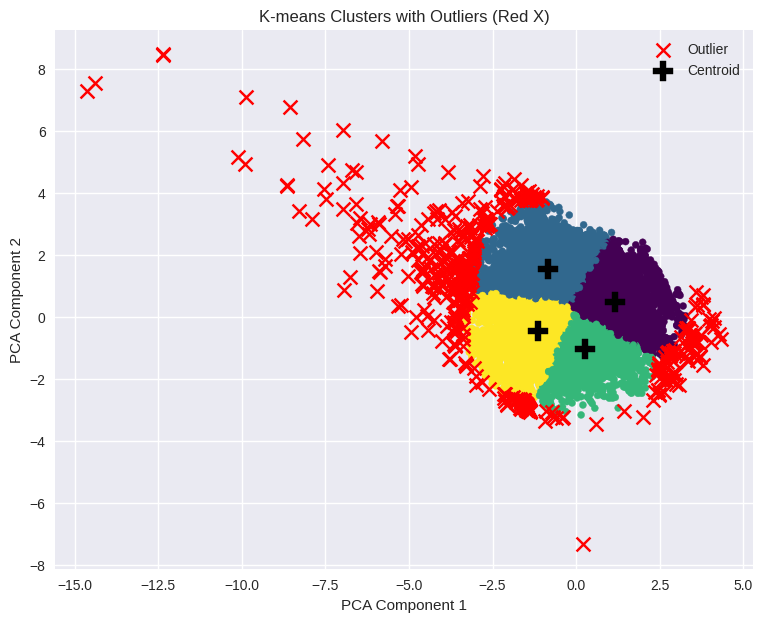

In [28]:
if 'X_pca' in globals() and 'kmeans' in globals():
    # Distance to own centroid
    dists = np.zeros(len(X_pca))
    for i in range(len(kmeans.centroids)):
        mask = kmeans.labels == i
        if mask.sum() > 0:
            dists[mask] = np.linalg.norm(X_pca[mask] - kmeans.centroids[i], axis=1)

    threshold = dists.mean() + 3 * dists.std()
    outliers = dists > threshold

    print(f"\nOutliers detected: {outliers.sum()} ({100*outliers.mean():.2f}% of data)")

    # Visualize
    plt.figure(figsize=(9, 7))
    plt.scatter(X_pca[~outliers,0], X_pca[~outliers,1], c=kmeans.labels[~outliers], cmap='viridis', s=25)
    plt.scatter(X_pca[outliers,0], X_pca[outliers,1], c='red', s=100, marker='x', label='Outlier')
    plt.scatter(kmeans.centroids[:,0], kmeans.centroids[:,1], c='black', s=200, marker='P', label='Centroid')
    plt.legend()
    plt.title('K-means Clusters with Outliers (Red X)')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.show()
else:
    print("X_pca or kmeans not defined.")